# Analysis of Zeek logs

In [1]:
import pandas as pd
import json
import gzip
import glob
import os
import seaborn as sb

%matplotlib inline
import matplotlib.pyplot as plt


### Extract gz files

In [2]:
path = './data/2020-06-03/' 
all_files = glob.glob(os.path.join(path,"conn.*.log.gz"))

In [6]:
df_list = []

for jsonfilename in all_files:
    with gzip.GzipFile(jsonfilename, 'r') as json_file:
        for line in json_file:
            json_data = json.loads(line)
           
            timestamp = json_data['ts']
            source_ip = json_data['id.orig_h']
            source_port = json_data['id.orig_p']
            destination_ip = json_data['id.resp_h']
            destination_port = json_data['id.resp_p']
            protocol = json_data['proto']
            
            if 'service' in json_data:
                service = json_data['service']
            else:
                service = 'NaN'
                
            connection_state = json_data['conn_state']

            df_list.append({'timestamp':pd.to_datetime(timestamp),
                           'source_ip': str(source_ip),
                           'source_port': int(source_port),
                           'destination_ip':str(destination_ip),
                           'destination_port':int(destination_port),
                           'protocol':str(protocol),
                           'service':str(service),
                           'connection_state':str(connection_state)})


Create data frame from dictionary

In [8]:
conn_df = pd.DataFrame(df_list, columns =['timestamp', 'source_ip', 'source_port', 'destination_ip', 
                                          'destination_port', 'protocol', 'service', 'connection_state'])
conn_df.head()

,timestamp,source_ip,source_port,destination_ip,destination_port,protocol,service,connection_state
0,1970-01-01 00:00:01.591124392,177.220.133.158,49491,115.186.176.141,22,tcp,ssh,SF
1,1970-01-01 00:00:01.591124395,123.25.13.20,51962,115.186.176.142,3389,tcp,ssl,RSTO
2,1970-01-01 00:00:01.591124399,195.144.21.185,61081,115.186.176.142,13331,tcp,NaN,S0
3,1970-01-01 00:00:01.591124400,139.59.58.115,57605,115.186.176.141,27529,tcp,NaN,REJ
4,1970-01-01 00:00:01.591124395,78.42.135.89,38256,115.186.176.141,22,tcp,ssh,SF


In [10]:
conn_df.shape

(51039, 8)

*Store dataframe to csv*

In [11]:
conn_df.to_csv('./data/2020-06-03/conn_logs.csv', index = False)

In [12]:
conn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51039 entries, 0 to 51038
Data columns (total 8 columns):
timestamp           51039 non-null datetime64[ns]
source_ip           51039 non-null object
source_port         51039 non-null int64
destination_ip      51039 non-null object
destination_port    51039 non-null int64
protocol            51039 non-null object
service             51039 non-null object
connection_state    51039 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.1+ MB


### Attackers Connections

In [13]:
df_merged = pd.read_csv('./data/2020-06-03/conn_logs.csv')

In [14]:
df_merged.head()

,timestamp,source_ip,source_port,destination_ip,destination_port,protocol,service,connection_state
0,1970-01-01 00:00:01.591124392,177.220.133.158,49491,115.186.176.141,22,tcp,ssh,SF
1,1970-01-01 00:00:01.591124395,123.25.13.20,51962,115.186.176.142,3389,tcp,ssl,RSTO
2,1970-01-01 00:00:01.591124399,195.144.21.185,61081,115.186.176.142,13331,tcp,NaN,S0
3,1970-01-01 00:00:01.591124400,139.59.58.115,57605,115.186.176.141,27529,tcp,NaN,REJ
4,1970-01-01 00:00:01.591124395,78.42.135.89,38256,115.186.176.141,22,tcp,ssh,SF


###  What are Attackers Source Ip's

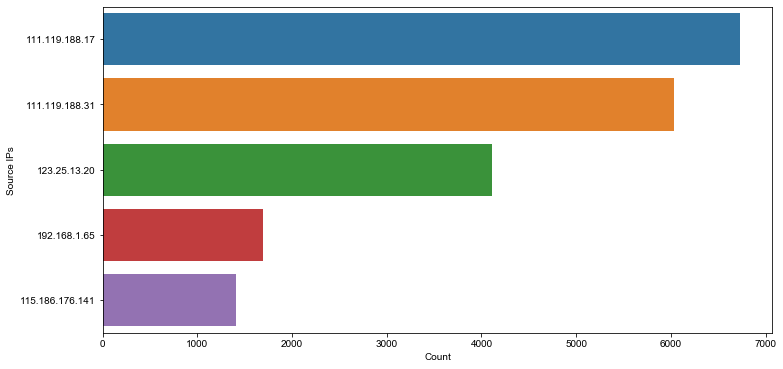

In [15]:
plt.figure(figsize=(12,6))
sb.countplot(data=df_merged, y='source_ip', order=df_merged.source_ip.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("dark")
plt.ylabel('Source IPs')
plt.xlabel('Count');

### Attackers Source Port

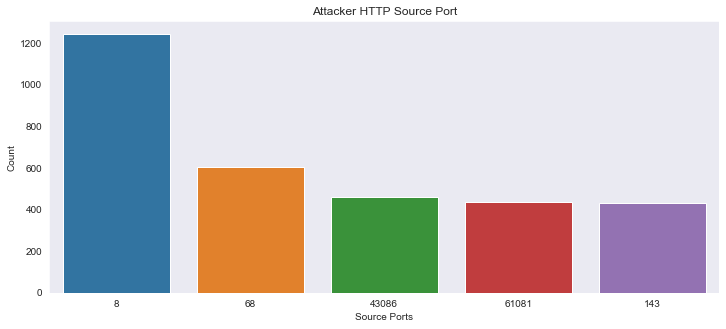

In [16]:

plt.figure(figsize=(12,5))
sb.countplot(data=df_merged, x='source_port', order=df_merged.source_port.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("dark")
plt.title('Attacker HTTP Source Port')
plt.ylabel('Count')
plt.xlabel('Source Ports');

### Attackers Destination IP

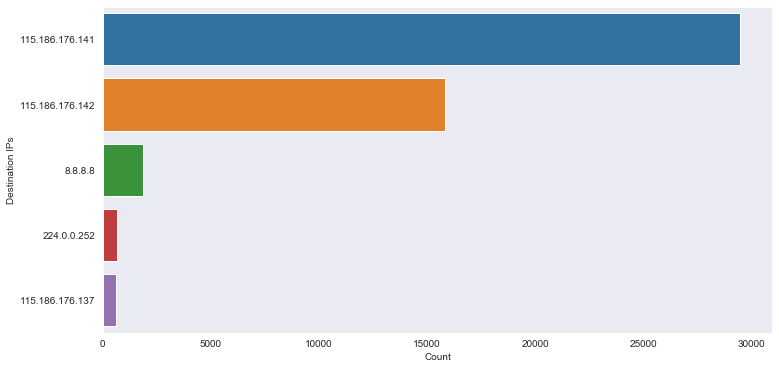

In [17]:
plt.figure(figsize=(12,6))
sb.countplot(data=df_merged, y='destination_ip', order=df_merged.destination_ip.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("whitegrid")
plt.ylabel('Destination IPs')
plt.xlabel('Count');

### Attackers Destination PORTs

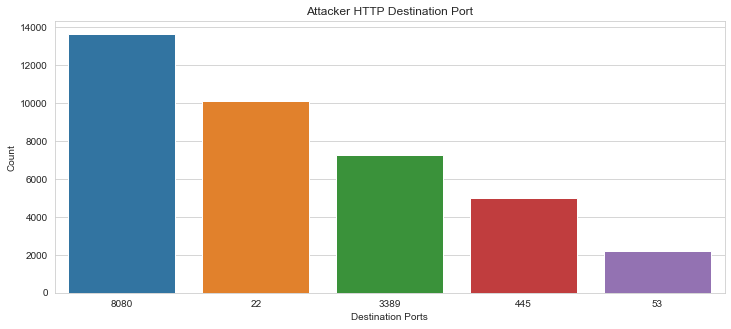

In [18]:
plt.figure(figsize=(12,5))
sb.countplot(data=df_merged, x='destination_port', order=df_merged.destination_port.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("dark")
plt.title('Attacker HTTP Destination Port')
plt.ylabel('Count')
plt.xlabel('Destination Ports');

### What are the services attacked?

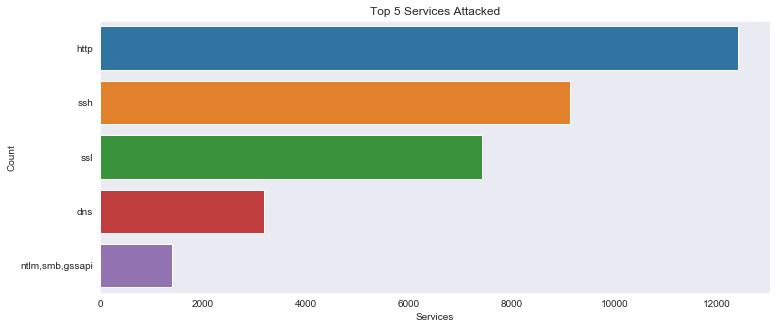

In [20]:
plt.figure(figsize=(12,5))
sb.countplot(data=df_merged, y='service', order=df_merged.service.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("dark")
plt.title('Top 5 Services Attacked')
plt.ylabel('Count')
plt.xlabel('Services');

### What are the protocols used by attacker

In [25]:
sum_proto = df_merged['protocol'].value_counts()

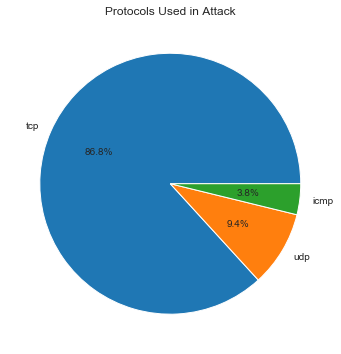

In [30]:
plt.figure(figsize=(6,6))
plt.pie(sum_proto, labels= sum_proto.index, autopct='%1.1f%%')
plt.title('Protocols Used in Attack')
plt.show();

### What are the connection states?

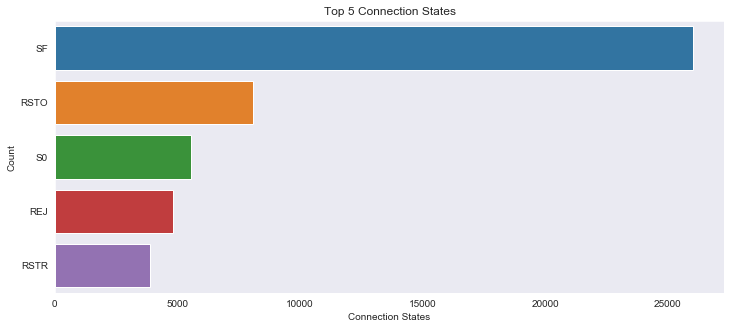

In [31]:
plt.figure(figsize=(12,5))
sb.countplot(data=df_merged, y='connection_state', order=df_merged.connection_state.value_counts().iloc[:5].index,
            orient = 'h');
sb.set_style("dark")
plt.title('Top 5 Connection States')
plt.ylabel('Count')
plt.xlabel('Connection States');